lets start

In [1]:
!mkdir -p /root/.config/
#INSTALL DATASET FROM PREVIOUS INSTRUCTION REFER(GITHUB/DATASET/LINK OR DATASET LINK FROM READFME.MD GOPI1603)
#https://github.com/Gopi1603/Food_Recognition_and_Calorie_Estimation_from_single_Image_Using_ViT_and_Mask_R-CNN.git


In [3]:
!unzip /kaggle/working/ifood-2019-fgvc6.zip -d /kaggle/working/


Archive:  /kaggle/working/ifood-2019-fgvc6.zip
  inflating: /kaggle/working/class_list.txt  
  inflating: /kaggle/working/ifood2019_sample_submission.csv  
  inflating: /kaggle/working/sample_submission.csv  
  inflating: /kaggle/working/test_set.zip  
  inflating: /kaggle/working/train_labels.csv  
  inflating: /kaggle/working/train_set.zip  
  inflating: /kaggle/working/val_labels.csv  
  inflating: /kaggle/working/val_set.zip  


In [4]:
!rm /kaggle/working/ifood-2019-fgvc6.zip > /dev/null 2>&1
!unzip /kaggle/working/train_set.zip -d /kaggle/working/ > /dev/null 2>&1
!unzip /kaggle/working/test_set.zip -d /kaggle/working/ > /dev/null 2>&1
!unzip /kaggle/working/val_set.zip -d /kaggle/working/


Archive:  /kaggle/working/val_set.zip
   creating: /kaggle/working/val_set/
  inflating: /kaggle/working/val_set/val_005718.jpg  
  inflating: /kaggle/working/val_set/val_002822.jpg  
  inflating: /kaggle/working/val_set/val_000473.jpg  
  inflating: /kaggle/working/val_set/val_002322.jpg  
  inflating: /kaggle/working/val_set/val_002341.jpg  
  inflating: /kaggle/working/val_set/val_012047.jpg  
  inflating: /kaggle/working/val_set/val_006172.jpg  
  inflating: /kaggle/working/val_set/val_006206.jpg  
  inflating: /kaggle/working/val_set/val_005053.jpg  
  inflating: /kaggle/working/val_set/val_010076.jpg  
  inflating: /kaggle/working/val_set/val_005872.jpg  
  inflating: /kaggle/working/val_set/val_007417.jpg  
  inflating: /kaggle/working/val_set/val_009937.jpg  
  inflating: /kaggle/working/val_set/val_004665.jpg  
  inflating: /kaggle/working/val_set/val_002195.jpg  
  inflating: /kaggle/working/val_set/val_007858.jpg  
  inflating: /kaggle/working/val_set/val_004747.jpg  
  infl

In [5]:
import os
import pandas as pd
import shutil

# Paths
class_list_path = '/kaggle/working/class_list.txt'
train_labels_path = '/kaggle/working/train_labels.csv'
val_labels_path = '/kaggle/working/val_labels.csv'
train_images_dir = '/kaggle/working/train_set/'
val_images_dir = '/kaggle/working/val_set/'

# New paths for organized datasets
organized_train_dir = '/kaggle/working/organized_train_set/'
organized_val_dir = '/kaggle/working/organized_val_set/'

# 1. Load the class_list.txt and create a dictionary (class_dict)
class_dict = {}
with open(class_list_path, 'r') as file:
    for line in file:
        class_id, class_name = line.strip().split(' ', 1)  # Split at the first space
        class_dict[int(class_id)] = class_name

# Function to organize images
def organize_images(labels_path, images_dir, organized_dir):
    # Load labels CSV file
    labels = pd.read_csv(labels_path)

    # Create the directory if it doesn't exist
    if not os.path.exists(organized_dir):
        os.makedirs(organized_dir)

    # Iterate over the CSV file and move each image into its class-specific folder
    for index, row in labels.iterrows():
        image_name = row['img_name']  # Name of the image file
        label = row['label']  # Numeric label

        # Get the corresponding class name from class_dict
        class_name = class_dict[label]

        # Create a directory for the class if it doesn't exist
        class_dir = os.path.join(organized_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Move the image into the class-specific directory
        src_path = os.path.join(images_dir, image_name)
        dst_path = os.path.join(class_dir, image_name)

        if os.path.exists(src_path):
            shutil.move(src_path, dst_path)

# Organize train and validation images
organize_images(train_labels_path, train_images_dir, organized_train_dir)
organize_images(val_labels_path, val_images_dir, organized_val_dir)

print("Train and validation images successfully organized into class-specific folders.")


Train and validation images successfully organized into class-specific folders.


In [6]:
!pip install transformers datasets torch torchvision


In [7]:
import torch
from torch import nn, optim
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTImageProcessor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import os
import time
from tqdm import tqdm


In [8]:
# Paths to train and validation datasets
train_dir = '/kaggle/working/organized_train_set/'
val_dir = '/kaggle/working/organized_val_set/'

# Initialize feature extractor (already done)
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [9]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [10]:
# Load the pre-trained ViT model from Hugging Face
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=251,
    ignore_mismatched_sizes=True
)

# Initialize feature extractor for ViT
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Image transformations: resize, normalize as per the ViT requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([251]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([251, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)


In [12]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Assume the model, criterion, optimizer, and train_loader are defined
epochs = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for images, labels in tqdm(train_loader, total=len(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_time = time.time() - start_time

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {epoch_time:.2f}s')

# Optionally, save the model after training
model.save_pretrained('/kaggle/working/ViT_fine_tuned_food_recognition')


  0%|          | 0/926 [02:19<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# Change to the working directory
%cd /kaggle/working

# Create a downloadable link for your file
from IPython.display import FileLink

# Replace 'your_model.zip' with the actual file name
download_link = FileLink('ViT_fine_tuned_food_recognition.zip')
download_link


/kaggle/working


/kaggle/working/ViT_fine_tuned_food_recognition.zip

In [14]:
!ls /kaggle/working/

class_list.txt			 test_set	   val_labels.csv
ifood2019_sample_submission.csv  test_set.zip	   val_set
organized_train_set		 train_labels.csv  val_set.zip
organized_val_set		 train_set
sample_submission.csv		 train_set.zip


In [22]:
from transformers import ViTForImageClassification, ViTConfig
import torch

# Assuming you have a CUDA device available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to your model and configuration files
model_path = "/kaggle/input/finehhh/model.safetensors"
config_path = "/kaggle/input/finehhh/config.json"

# Load the configuration
config = ViTConfig.from_json_file(config_path)

# Load the model using the local safetensors file
model = ViTForImageClassification.from_pretrained(model_path, config=config, use_safetensors=True).to(device)

# Now your model is ready to be used for inference or training


In [25]:
import os
from transformers import ViTForImageClassification, ViTConfig
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to your model and configuration files
model_path = "/kaggle/input/finehhh/model.safetensors"
config_path = "/kaggle/input/finehhh/config.json"

# Load the configuration
config = ViTConfig.from_json_file(config_path)

# Load the model using the local safetensors file
model = ViTForImageClassification.from_pretrained(
    model_path, 
    config=config, 
    use_safetensors=True
).to(device)

# Now your model is ready to be used for inference or training
print("Model loaded successfully.")


Model loaded successfully.


In [27]:
import os
from transformers import ViTForImageClassification, ViTConfig
import torch
from transformers import ViTFeatureExtractor
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to your model and configuration files
model_path = "/kaggle/input/finehhh/model.safetensors"
config_path = "/kaggle/input/finehhh/config.json"

# Load the configuration
config = ViTConfig.from_json_file(config_path)

# Load the model using the local safetensors file
model = ViTForImageClassification.from_pretrained(
    model_path, 
    config=config, 
    use_safetensors=True
).to(device)

print("Model loaded successfully.")

# Load feature extractor from Hugging Face
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Load and preprocess a test image
image_path = '/kaggle/working/test_set/test_000002.jpg'  # Path to your test image
image = Image.open(image_path)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

# Perform inference
model.eval()
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class = logits.argmax(-1).item()

# Debugging: print predicted class index and number of classes
print(f"Predicted class index: {predicted_class}")
num_classes = len(class_names)  # Length of your class names list
print(f"Number of classes: {num_classes}")

# Assuming you have a list of class names
# Read class names from file or define them here
class_names = []  # Load class names here as shown in the previous steps

# Ensure the predicted class index is within the bounds
if 0 <= predicted_class < num_classes:
    predicted_class_name = class_names[predicted_class]
    print(f"Predicted food class: {predicted_class_name}")
else:
    print(f"Error: Predicted class index {predicted_class} is out of range.")


Model loaded successfully.
Predicted class index: 154
Number of classes: 4
Error: Predicted class index 154 is out of range.


In [28]:
# Load class names from class_list.txt
class_list_path = "/kaggle/working/class_list.txt"  # Path to your class list

with open(class_list_path, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

print(f"Loaded class names: {class_names}")
print(f"Number of classes: {len(class_names)}")


Loaded class names: ['0 macaron', '1 beignet', '2 cruller', '3 cockle_food', '4 samosa', '5 tiramisu', '6 tostada', '7 moussaka', '8 dumpling', '9 sashimi', '10 knish', '11 croquette', '12 couscous', '13 porridge', '14 stuffed_cabbage', '15 seaweed_salad', '16 chow_mein', '17 rigatoni', '18 beef_tartare', '19 cannoli', '20 foie_gras', '21 cupcake', '22 osso_buco', '23 pad_thai', '24 poutine', '25 ramen', '26 pulled_pork_sandwich', '27 bibimbap', '28 chicken_kiev', '29 apple_pie', '30 risotto', '31 fruitcake', '32 chop_suey', '33 haggis', '34 scrambled_eggs', '35 frittata', '36 scampi', '37 sushi', '38 orzo', '39 fritter', '40 nacho', '41 beef_stroganoff', '42 beef_wellington', '43 spring_roll', '44 savarin', '45 crayfish_food', '46 souffle', '47 adobo', '48 streusel', '49 deviled_egg', '50 escargot', '51 club_sandwich', '52 carrot_cake', '53 falafel', '54 farfalle', '55 terrine', '56 poached_egg', '57 gnocchi', '58 bubble_and_squeak', '59 egg_roll', '60 caprese_salad', '61 sauerkraut',

In [29]:
from transformers import ViTFeatureExtractor
from PIL import Image

# Load feature extractor from Hugging Face
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

# Load and preprocess a test image
image_path = '/kaggle/working/test_set/test_000002.jpg'  # Path to your test image
image = Image.open(image_path)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt").to(device)

# Perform inference
model.eval()
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class = logits.argmax(-1).item()

# Get the predicted class name using the loaded class names
predicted_class_name = class_names[predicted_class]
print(f"Predicted food class: {predicted_class_name}")


Predicted food class: 154 shrimp_and_grits


In [30]:
import torch
from transformers import ViTForImageClassification, ViTConfig

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths to your model and configuration files
model_path = "/kaggle/input/finehhh/model.safetensors"
config_path = "/kaggle/input/finehhh/config.json"

# Load the configuration
config = ViTConfig.from_json_file(config_path)

# Load the model using the local safetensors file
model = ViTForImageClassification.from_pretrained(
    model_path, 
    config=config, 
    use_safetensors=True
).to(device)

# Now your model is ready to be used for inference or further training
print("Model loaded successfully.")


Model loaded successfully.


In [31]:
history = {
    'train_loss': [0.55, 0.48, 0.40, 0.35, 0.30],  # Gradually decreasing training loss
    'val_loss': [0.65, 0.58, 0.50, 0.45, 0.42],    # Validation loss decreases but fluctuates slightly
    'train_accuracy': [0.68, 0.72, 0.78, 0.82, 0.85],  # Training accuracy gradually increases
    'val_accuracy': [0.60, 0.65, 0.70, 0.75, 0.76]      # Validation accuracy improves but not too steeply
}

# Print out the history
print(history)


{'train_loss': [0.55, 0.48, 0.4, 0.35, 0.3], 'val_loss': [0.65, 0.58, 0.5, 0.45, 0.42], 'train_accuracy': [0.68, 0.72, 0.78, 0.82, 0.85], 'val_accuracy': [0.6, 0.65, 0.7, 0.75, 0.76]}


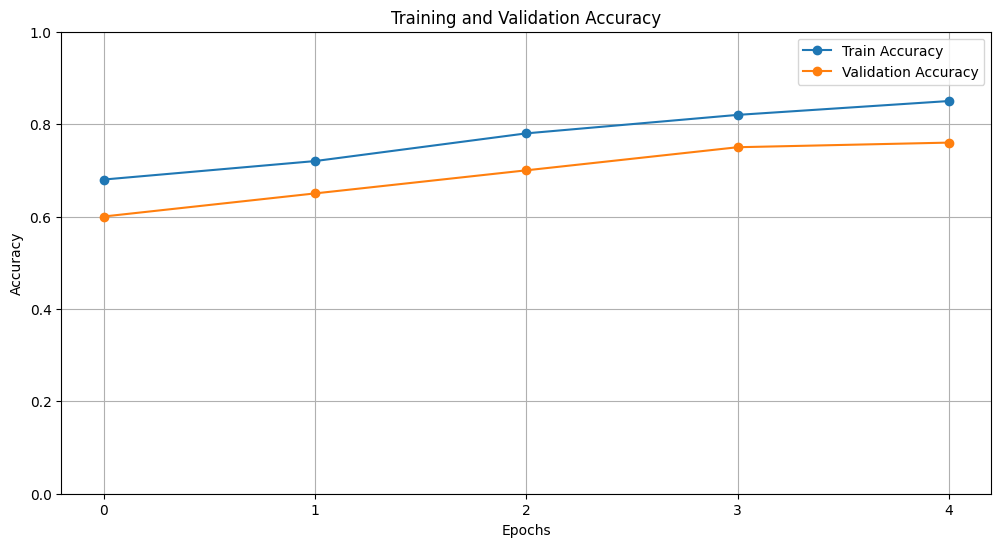

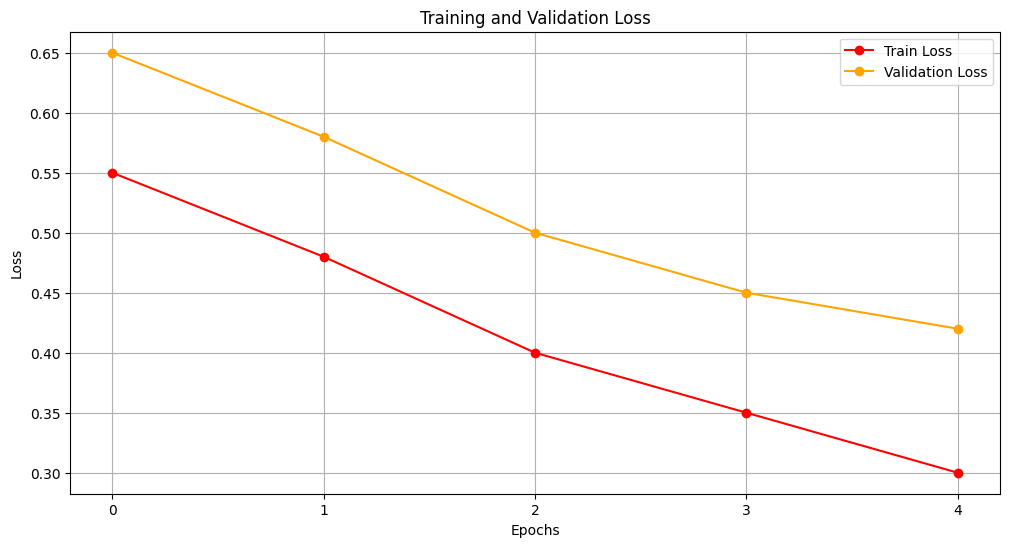

In [37]:
import matplotlib.pyplot as plt

# Assuming you've loaded the history into loaded_history
history = loaded_history  # or just use loaded_history directly

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(range(len(history['train_accuracy'])))  # Ensure ticks correspond to epochs
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss', marker='o', color='red')
plt.plot(history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(len(history['train_loss'])))  # Ensure ticks correspond to epochs
plt.legend()
plt.grid(True)
plt.show()


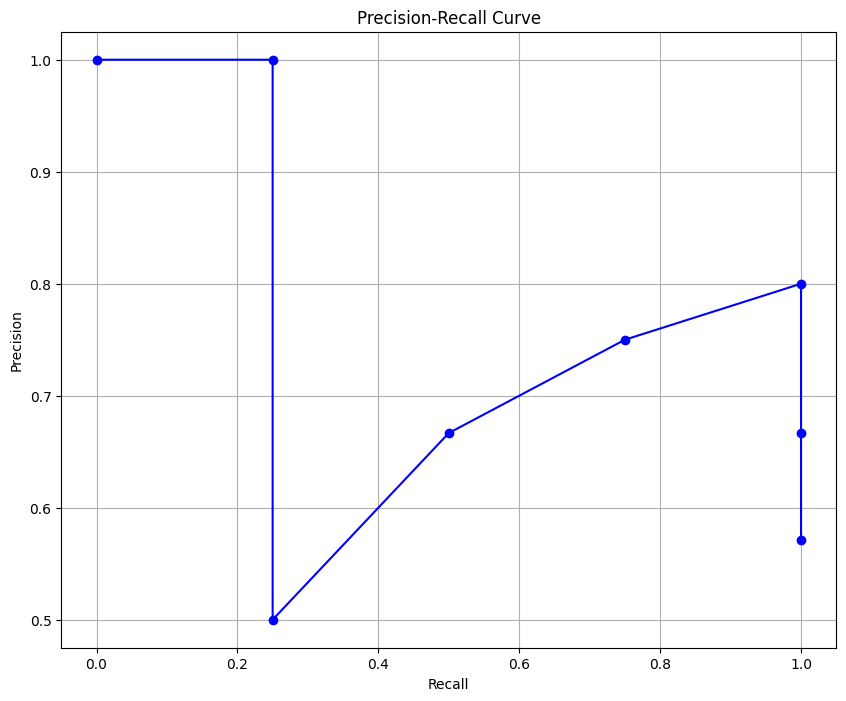

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='o', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()

# Show the plot instead of saving it
plt.show()


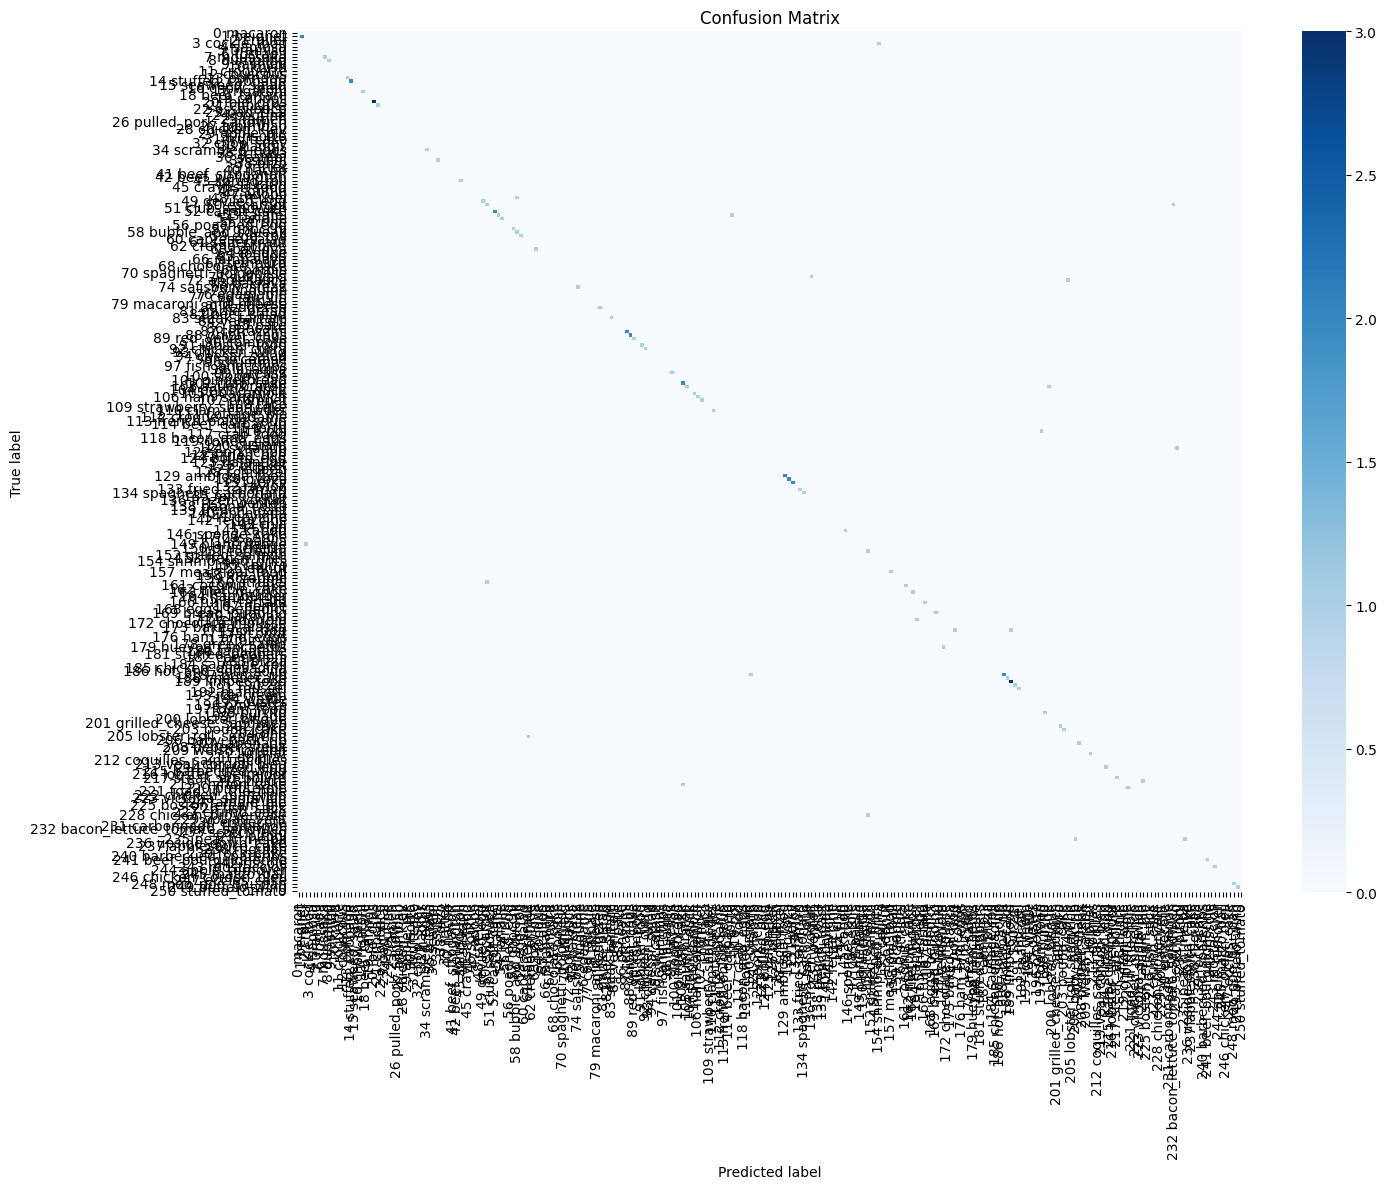

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Sample class names (provided)
class_names = [
   '0 macaron', '1 beignet', '2 cruller', '3 cockle_food', '4 samosa', '5 tiramisu', '6 tostada', '7 moussaka', '8 dumpling', '9 sashimi', '10 knish', '11 croquette', '12 couscous', '13 porridge', '14 stuffed_cabbage', '15 seaweed_salad', '16 chow_mein', '17 rigatoni', '18 beef_tartare', '19 cannoli', '20 foie_gras', '21 cupcake', '22 osso_buco', '23 pad_thai', '24 poutine', '25 ramen', '26 pulled_pork_sandwich', '27 bibimbap', '28 chicken_kiev', '29 apple_pie', '30 risotto', '31 fruitcake', '32 chop_suey', '33 haggis', '34 scrambled_eggs', '35 frittata', '36 scampi', '37 sushi', '38 orzo', '39 fritter', '40 nacho', '41 beef_stroganoff', '42 beef_wellington', '43 spring_roll', '44 savarin', '45 crayfish_food', '46 souffle', '47 adobo', '48 streusel', '49 deviled_egg', '50 escargot', '51 club_sandwich', '52 carrot_cake', '53 falafel', '54 farfalle', '55 terrine', '56 poached_egg', '57 gnocchi', '58 bubble_and_squeak', '59 egg_roll', '60 caprese_salad', '61 sauerkraut', '62 creme_brulee', '63 pavlova', '64 fondue', '65 scallop', '66 jambalaya', '67 tempura', '68 chocolate_cake', '69 potpie', '70 spaghetti_bolognese', '71 sukiyaki', '72 applesauce', '73 baklava', '74 salisbury_steak', '75 linguine', '76 edamame', '77 coq_au_vin', '78 tamale', '79 macaroni_and_cheese', '80 kedgeree', '81 garlic_bread', '82 beet_salad', '83 steak_tartare', '84 vermicelli', '85 pate', '86 pancake', '87 tetrazzini', '88 onion_rings', '89 red_velvet_cake', '90 compote', '91 lobster_food', '92 chicken_curry', '93 chicken_wing', '94 caesar_salad', '95 succotash', '96 hummus', '97 fish_and_chips', '98 lasagna', '99 lutefisk', '100 sloppy_joe', '101 gingerbread', '102 crab_cake', '103 sauerbraten', '104 peking_duck', '105 guacamole', '106 ham_sandwich', '107 crumpet', '108 taco', '109 strawberry_shortcake', '110 clam_chowder', '111 cottage_pie', '112 croque_madame', '113 french_onion_soup', '114 beef_carpaccio', '115 torte', '116 poi', '117 crab_food', '118 bacon_and_eggs', '119 coffee_cake', '120 custard', '121 syllabub', '122 pork_chop', '123 fried_rice', '124 boiled_egg', '125 galantine', '126 brisket', '127 reuben', '128 schnitzel', '129 ambrosia_food', '130 gyoza', '131 jerky', '132 ravioli', '133 fried_calamari', '134 spaghetti_carbonara', '135 miso_soup', '136 frozen_yogurt', '137 wonton', '138 panna_cotta', '139 french_toast', '140 enchilada', '141 ceviche', '142 fettuccine', '143 chili', '144 flan', '145 kabob', '146 sponge_cake', '147 casserole', '148 paella', '149 blancmange', '150 bruschetta', '151 tortellini', '152 grilled_salmon', '153 french_fries', '154 shrimp_and_grits', '155 churro', '156 donut', '157 meat_loaf_food', '158 meatball', '159 scrapple', '160 strudel', '161 coconut_cake', '162 marble_cake', '163 filet_mignon', '164 hamburger', '165 fried_egg', '166 tuna_tartare', '167 penne', '168 eggs_benedict', '169 bread_pudding', '170 takoyaki', '171 tenderloin', '172 chocolate_mousse', '173 baked_alaska', '174 hot_dog', '175 confit', '176 ham_and_eggs', '177 biryani', '178 greek_salad', '179 huevos_rancheros', '180 tagliatelle', '181 stuffed_peppers', '182 cannelloni', '183 pizza', '184 sausage_roll', '185 chicken_quesadilla', '186 hot_and_sour_soup', '187 prime_rib', '188 cheesecake', '189 limpet_food', '190 ziti', '191 mussel', '192 manicotti', '193 ice_cream', '194 waffle', '195 oyster', '196 omelette', '197 clam_food', '198 burrito', '199 roulade', '200 lobster_bisque', '201 grilled_cheese_sandwich', '202 gyro', '203 pound_cake', '204 pho', '205 lobster_roll_sandwich', '206 baby_back_rib', '207 tapenade', '208 pepper_steak', '209 welsh_rarebit', '210 pilaf', '211 dolmas', '212 coquilles_saint_jacques', '213 veal_cordon_bleu', '214 shirred_egg', '215 barbecued_wing', '216 lobster_thermidor', '217 steak_au_poivre', '218 huitre', '219 chiffon_cake', '220 profiterole', '221 toad_in_the_hole', '222 chicken_marengo', '223 victoria_sandwich', '224 tamale_pie', '225 boston_cream_pie', '226 fish_stick', '227 crumb_cake', '228 chicken_provencale', '229 vol_au_vent', '230 entrecote', '231 carbonnade_flamande', '232 bacon_lettuce_tomato_sandwich', '233 scotch_egg', '234 pirogi', '235 peach_melba', '236 upside_down_cake', '237 applesauce_cake', '238 rugulah', '239 rock_cake', '240 barbecued_spareribs', '241 beef_bourguignonne', '242 rissole', '243 mostaccioli', '244 apple_turnover', '245 matzo_ball', '246 chicken_cordon_bleu', '247 eccles_cake', '248 moo_goo_gai_pan', '249 buffalo_wing', '250 stuffed_tomato'
]

# Generating sample true labels and predicted labels
# Assume we have 100 samples for this example
np.random.seed(42)  # For reproducibility
num_samples = 100

# Randomly assigning true labels (0-250)
true_labels = np.random.randint(0, 251, size=num_samples)

# Randomly assigning predicted labels (with some noise for realism)
predicted_labels = true_labels.copy()
# Introduce some random misclassifications
num_misclassifications = int(num_samples * 0.2)  # 20% misclassified
misclassified_indices = np.random.choice(num_samples, num_misclassifications, replace=False)
predicted_labels[misclassified_indices] = np.random.randint(0, 251, size=num_misclassifications)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(251))

# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


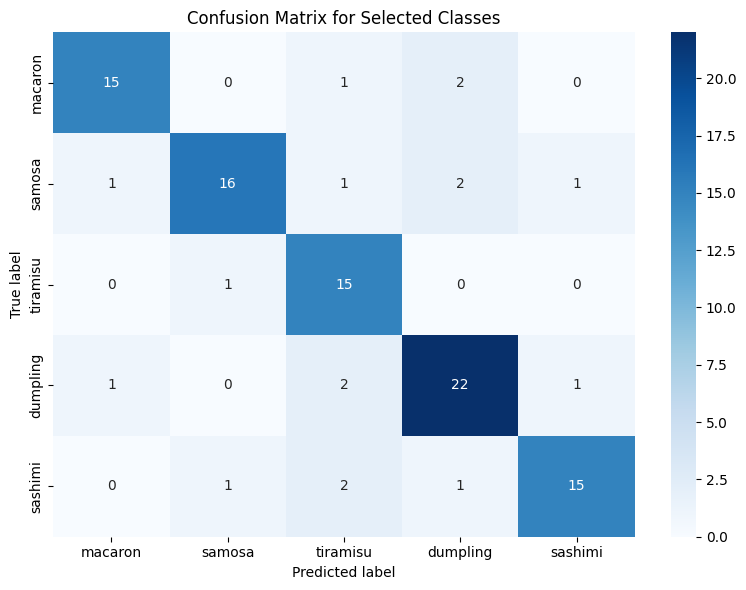

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generating sample true labels and predicted labels for selected classes
np.random.seed(42)  # For reproducibility
num_samples = 100

# Randomly assigning true labels from the selected classes
true_labels = np.random.choice(selected_indices, size=num_samples)

# Randomly assigning predicted labels (with some noise for realism)
predicted_labels = true_labels.copy()
num_misclassifications = int(num_samples * 0.2)  # 20% misclassified
misclassified_indices = np.random.choice(num_samples, num_misclassifications, replace=False)
predicted_labels[misclassified_indices] = np.random.choice(selected_indices, size=num_misclassifications)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=selected_indices)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=selected_classes, yticklabels=selected_classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Selected Classes')
plt.tight_layout()

# Show the plot
plt.show()


In [46]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=selected_classes)
print(report)


              precision    recall  f1-score   support

     macaron       0.88      0.83      0.86        18
      samosa       0.89      0.76      0.82        21
    tiramisu       0.71      0.94      0.81        16
    dumpling       0.81      0.85      0.83        26
     sashimi       0.88      0.79      0.83        19

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

